# Interoperability with `scirpy`

It is now possible to convert the file formats between `dandelion>=0.1.1` and `scirpy>=0.6.2` [[Sturm2020]](https://academic.oup.com/bioinformatics/article/36/18/4817/5866543) to enhance the collaboration between the analysis toolkits.

We will download the *airr_rearrangement.tsv* file from here:
```bash
# bash
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv
```


<b>Import dandelion module</b>

In [1]:
import os
import dandelion as ddl

# change directory to somewhere more workable
os.chdir(os.path.expanduser("~/Downloads/dandelion_tutorial/"))
ddl.logging.print_versions()

dandelion==0.3.4.dev30 pandas==2.0.1 numpy==1.24.3 matplotlib==3.7.1 networkx==3.1 scipy==1.11.2


In [2]:
import scirpy as ir

ir.__version__

'0.14.0'

## `dandelion`

In [3]:
# read in the airr_rearrangement.tsv file
file_location = (
    "sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv"
)
vdj = ddl.read_10x_airr(file_location)
vdj

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'rearrangement_status'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_

The test file contains a blank `clone_id` column so we run `find_clones` to populate it first.

In [4]:
ddl.tl.find_clones(vdj)

Finding clones based on B cell VJ chains : 100%|██████████| 164/164 [00:00<00:00, 3282.43it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 994/994 [00:00<00:00, 255649.88it/s]


### `ddl.to_scirpy` : Converting `dandelion` to `scirpy`

In [5]:
irdata = ddl.to_scirpy(vdj)
irdata

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/aligned_mapping.py:54: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!


AnnData object with n_obs × n_vars = 994 × 0
    uns: 'scirpy_version'
    obsm: 'airr'

to transfer every column found in a dandelion airr object (including things like `germline_alignment_d_mask`) do:

In [6]:
irdata = ddl.to_scirpy(vdj, include_fields=vdj.data.columns)
irdata

AnnData object with n_obs × n_vars = 994 × 0
    uns: 'scirpy_version'
    obsm: 'airr'

The `clone_id` is mapped to `IR_VJ_1_clone_id` column.

`transfer = True` will perform dandelion's `tl.transfer`.

In [7]:
irdatax = ddl.to_scirpy(vdj, transfer=True)
irdatax

AnnData object with n_obs × n_vars = 994 × 0
    obs: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
    uns: 'scirpy_version'
    obsm: 'airr'

### `ddl.from_scirpy` : Converting `scirpy` to `dandelion`

In [8]:
vdjx = ddl.from_scirpy(irdata)
vdjx

  0%|          | 0/1 [00:00<?, ?it/s]

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_sequence_end', 'd_sequence_start', 'duplicate_count', 'is_cell', 'j_sequence_end', 'j_sequence_start', 'junction_aa_length', 'junction_length', 'locus', 'rearrangement_status', 'sequence_aa', 'v_sequence_end', 'v_sequence_start', 'cell_id'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive

In [9]:
vdjx.metadata

,clone_id,clone_id_by_size,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_VDJ,d_call_VDJ,j_call_VDJ,v_call_VJ,...,d_call_B_VDJ_main,j_call_B_VDJ_main,v_call_B_VJ_main,j_call_B_VJ_main,isotype,isotype_status,locus_status,chain_status,rearrangement_status_VDJ,rearrangement_status_VJ
AAACCTGTCATATCGG-1,B_VJ_28_1_2,13,None,IGK,None,True,None,None,None,IGKV1-8,...,None,None,IGKV1-8,IGKJ4,None,None,Orphan IGK,Orphan VJ,None,standard
AAACCTGTCCGTTGTC-1,B_VDJ_119_3_1_VJ_127_2_1,961,IGH,IGK,True,True,IGHV1-69D,IGHD3-22,IGHJ3,IGKV1-8,...,IGHD3-22,IGHJ3,IGKV1-8,IGKJ1,IgM,IgM,IGH + IGK,Single pair,standard,standard
AAACCTGTCGAGAACG-1,B_VDJ_95_4_1_VJ_123_1_2,777,IGH,IGL,True,True,IGHV1-2,None,IGHJ3,IGLV5-45,...,None,IGHJ3,IGLV5-45,IGLJ3,IgM,IgM,IGH + IGL,Single pair,standard,standard
AAACCTGTCTTGAGAC-1,B_VDJ_50_1_2_VJ_35_1_1,776,IGH,IGK,True,True,IGHV5-51,None,IGHJ3,IGKV1D-8,...,None,IGHJ3,IGKV1D-8,IGKJ2,IgM,IgM,IGH + IGK,Single pair,standard,standard
AAACGGGAGCGACGTA-1,B_VDJ_6_1_1_VJ_158_2_3,775,IGH,IGL,True,True,IGHV4-59,None,IGHJ3,IGLV3-19,...,None,IGHJ3,IGLV3-19,IGLJ2,IgM,IgM,IGH + IGL,Single pair,standard,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCTAACGGT-1,B_VDJ_78_3_1_VJ_44_1_2,389,IGH,IGL,True,True,IGHV3-43,None,IGHJ6,IGLV2-8,...,None,IGHJ6,IGLV2-8,IGLJ3,IgM,IgM,IGH + IGL,Single pair,standard,standard
TTTGGTTGTAGCCTAT-1,B_VDJ_73_1_1_VJ_85_2_1,388,IGH,IGK,True,True,IGHV4-39,None,IGHJ2,IGKV6-21,...,None,IGHJ2,IGKV6-21,IGKJ4,IgM,IgM,IGH + IGK,Single pair,standard,standard
TTTGGTTTCAGAGCTT-1,B_VDJ_69_5_1_VJ_47_1_1,387,IGH,IGK,True,True,IGHV7-4-1,IGHD3-10,IGHJ4,IGKV3-11,...,IGHD3-10,IGHJ4,IGKV3-11,IGKJ5,IgM,IgM,IGH + IGK,Single pair,standard,standard
TTTGGTTTCAGTGTTG-1,B_VDJ_68_1_1_VJ_34_2_1,386,IGH,IGL,True,True,IGHV2-5,None,IGHJ4,IGLV2-23,...,None,IGHJ4,IGLV2-23,IGLJ2,IgM,IgM,IGH + IGL,Single pair,standard,standard


## `scirpy`

### `ir.io.from_dandelion` : Converting `dandelion` to `scirpy`

In [10]:
irdata2 = ir.io.from_dandelion(vdj, include_fields=vdj.data.columns)
irdata2

AnnData object with n_obs × n_vars = 994 × 0
    uns: 'scirpy_version'
    obsm: 'airr'

likewise, `transfer = True` will perform dandelion's `tl.transfer`.

In [11]:
irdata2x = ir.io.from_dandelion(
    vdj, transfer=True, include_fields=vdj.data.columns
)
irdata2x

AnnData object with n_obs × n_vars = 994 × 0
    obs: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
    uns: 'scirpy_version'
    obsm: 'airr'

### `ir.io.to_dandelion` : Converting `scirpy` to `dandelion`

In [12]:
vdj3 = ir.io.to_dandelion(irdata2)
vdj3

  0%|          | 0/1 [00:00<?, ?it/s]

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_sequence_end', 'd_sequence_start', 'duplicate_count', 'is_cell', 'j_sequence_end', 'j_sequence_start', 'junction_aa_length', 'junction_length', 'locus', 'rearrangement_status', 'sequence_aa', 'v_sequence_end', 'v_sequence_start', 'cell_id'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive

### Example of reading with `scirpy` followed by conversion to `dandelion`

In [13]:
# read in the airr_rearrangement.tsv file
file_location = (
    "sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv"
)
irdata_s = ir.io.read_airr(file_location)
irdata_s

AnnData object with n_obs × n_vars = 994 × 0
    uns: 'scirpy_version'
    obsm: 'airr'

This time, find clones with `scirpy`'s method.

In [14]:
ir.tl.chain_qc(irdata_s)
ir.pp.ir_dist(irdata_s, metric="hamming", sequence="aa")
ir.tl.define_clonotypes(irdata_s)
irdata_s

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/984 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 994 × 0
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
    uns: 'scirpy_version', 'chain_indices', 'ir_dist_aa_hamming', 'ir_dist_nt_identity', 'clone_id'
    obsm: 'airr', 'chain_indices'

In [15]:
vdj4 = ir.io.to_dandelion(irdata_s)
vdj4

  0%|          | 0/1 [00:00<?, ?it/s]

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_sequence_end', 'd_sequence_start', 'duplicate_count', 'is_cell', 'j_sequence_end', 'j_sequence_start', 'junction_aa_length', 'junction_length', 'locus', 'sequence_aa', 'v_sequence_end', 'v_sequence_start', 'cell_id', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id_size', 'rearrangement_status'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_cal

### Visualising with `scirpy`'s plotting tools

You can now also plot `dandelion` networks using `scirpy`'s functions.

In [16]:
ddl.tl.generate_network(vdj, key="junction")

Setting up data: 2093it [00:00, 8097.61it/s]
Linking edges : 100%|██████████| 984/984 [00:00<00:00, 23348.62it/s]


Computing network layout
Computing expanded network layout


In [17]:
irdata_s.obs["scirpy_clone_id"] = irdata_s.obs["clone_id"]  # stash it
ddl.tl.transfer(
    irdata_s, vdj, overwrite=True
)  # overwrite scirpy's clone_id definition

<Axes: >

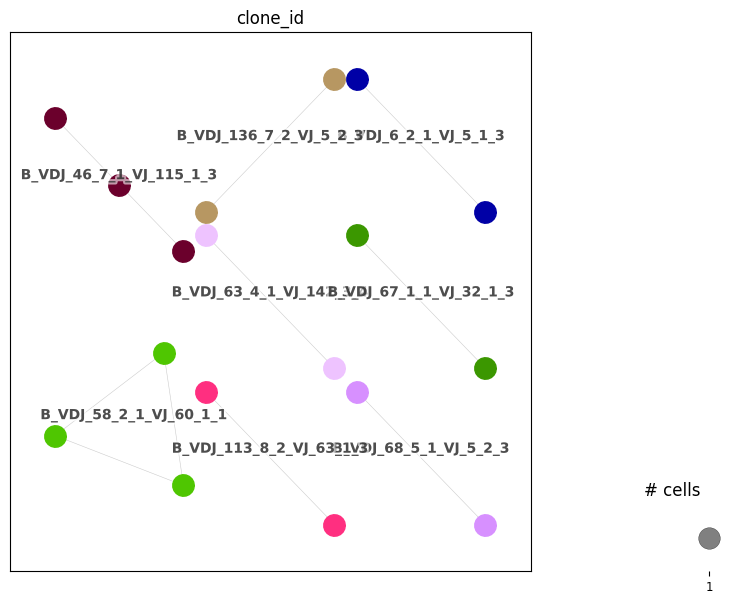

In [18]:
ir.tl.clonotype_network(irdata_s, min_cells=2)
ir.pl.clonotype_network(irdata_s, color="clone_id", panel_size=(7, 7))

to swap to a shorter clone_id name (ordered by size)

<Axes: >

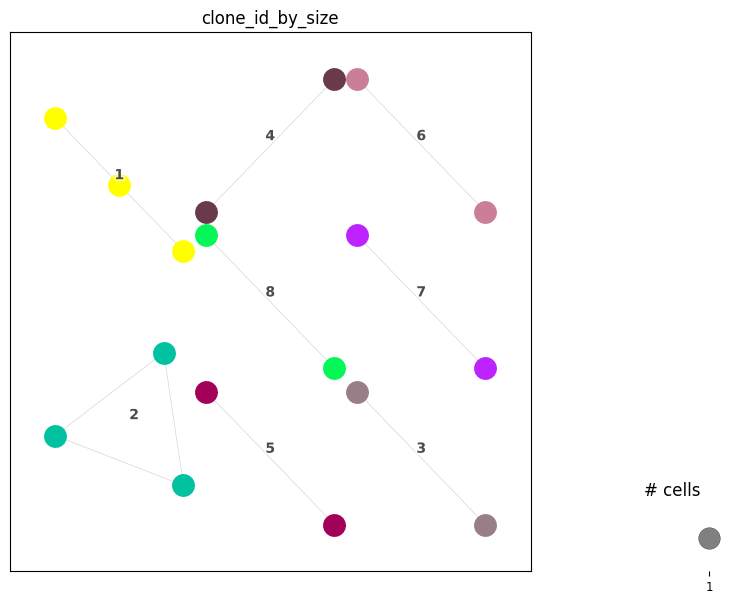

In [19]:
ddl.tl.transfer(irdata_s, vdj, clone_key="clone_id_by_size")
ir.tl.clonotype_network(irdata_s, clonotype_key="clone_id_by_size", min_cells=2)
ir.pl.clonotype_network(irdata_s, color="clone_id_by_size", panel_size=(7, 7))

you can also collapse the networks to a single node and plot by size

<Axes: >

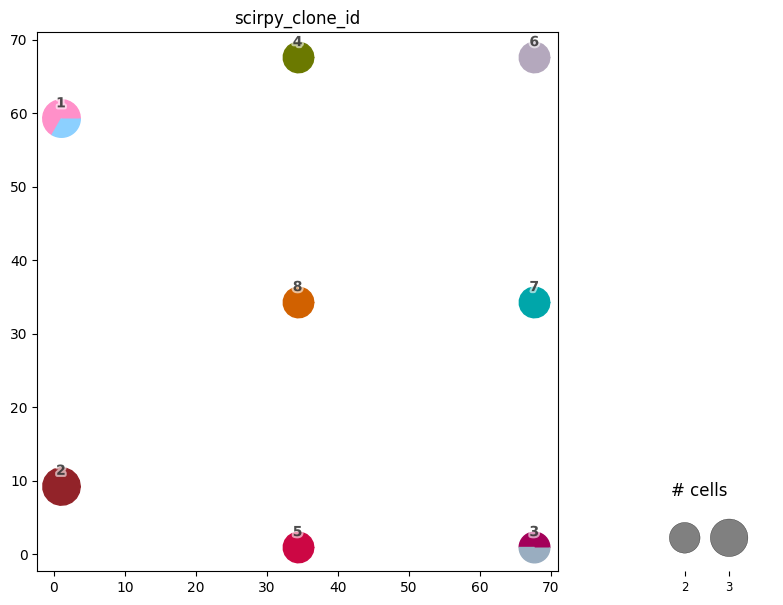

In [20]:
ddl.tl.transfer(
    irdata_s, vdj, clone_key="clone_id_by_size", collapse_nodes=True
)
ir.tl.clonotype_network(irdata_s, clonotype_key="clone_id_by_size", min_cells=2)
ir.pl.clonotype_network(irdata_s, color="scirpy_clone_id", panel_size=(7, 7))